In [1]:
import numpy as np 
import pandas as pd 

import lightgbm as lgb
import catboost

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp

import warnings, random, gc, os,datetime, shap,pickle
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 4242
set_seed(SEED)

lgb_params = {
    'objective':'cross_entropy',
    'boosting_type':'gbdt',
    'metric':'auc',
    'n_jobs':-1,
    'seed': SEED,
    'is_unbalance': True,
    
    'learning_rate':0.01,

    'num_leaves': 60,
    'max_depth': 7,
    'subsample_freq':1,
    'subsample':0.7,
    'colsample_bytree': 0.7
    } 

# load

In [3]:
def get_df(df_path, dtypes_path):
    path = '../input/fork-of-fork-of-fork-of-fork-of-adversarial-ieee-8/'
    df_dtypes = pd.read_csv('../input/ieee-cis-data/' + dtypes_path)
    df_dtypes = df_dtypes.rename(columns={'TransactionID': 'col','int32': 'type'})
    df_dtypes = df_dtypes.to_dict(orient='records')
    new_dtypes = dict()
    for rec in df_dtypes:
        new_dtypes[rec['col']] = rec['type']
    new_dtypes['TransactionID'] = 'int32'

    df = pd.read_csv(path+df_path, dtype=new_dtypes)
    del df_dtypes, new_dtypes
    gc.collect()
    return df

def load_data():
    train = get_df('tr_smooth.csv', 'train_dtypes.csv')
    test = get_df('te_smooth.csv', 'test_dtypes.csv')
    sub = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
    return train, test, sub

def get_x_y(train, test):
    X = train.sort_values('TransactionDT').drop(['isFraud',  'TransactionID','TransactionDT'], axis=1)
    y_train = train.sort_values('TransactionDT')['isFraud']
    X_test = test.sort_values('TransactionDT').drop(['TransactionID','TransactionDT'], axis=1)
    del train
    gc.collect()
    test = test[["TransactionDT", 'TransactionID']]
    return X,y_train,X_test, test

def reduce_memory_usage(df, cols=None):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    if cols is None:
        cols = df.columns
    for col in tqdm(cols):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
            start_mem - end_mem) / start_mem))
        

def save_pickle(df, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(filename):
#     filename = '../input/fork-of-fork-of-adversarial-ieee-8ed3d0/' + filename
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
        return data, list(data.columns)


def assemble_data(pickle_list, path):
    assembled_data, assembled_cols = load_pickle(path+pickle_list[0])
    for filename in pickle_list:
        if filename == pickle_list[0]:
            continue
        data, cols = load_pickle(path+filename)
        assembled_data = np.hstack((assembled_data, data))
        for col in cols:
            assembled_cols.append(col)
    return pd.DataFrame(assembled_data, columns=assembled_cols), assembled_cols

# adv

In [4]:
def get_adversarial_train(X, X_test,seed=SEED):
    X["is_test"] = 0
    X_test["is_test"] = 1
    assert(np.all(X_train.columns == X_test.columns))
    
    total = pd.concat([X, X_test])
    del X, X_test
    gc.collect()
    
    X_split = total.drop(["is_test"], axis = 1)
    y_split = total.is_test
    del total
    gc.collect()
    
    dataX_train, dataX_valid, datay_train, datay_valid = train_test_split(X_split,y_split, test_size=0.2, random_state=seed)
    del X_split,y_split
    gc.collect()
    
    dtrain = lgb.Dataset(data=dataX_train, label=datay_train,free_raw_data=False)
    del dataX_train, datay_train
    gc.collect()
    
    dval = lgb.Dataset(data=dataX_valid, label=datay_valid,free_raw_data=False)
    del dataX_valid, datay_valid
    gc.collect()

    clf = lgb.train(lgb_params, dtrain, 
                    num_boost_round=1000,
                    verbose_eval=200,
                    early_stopping_rounds=100, 
                    valid_sets = [dtrain, dval])
    
    feature_importance = pd.DataFrame()
    feature_importance["feature"] = X.columns
    feature_importance["importance"] = clf.feature_importance()

    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values("importance", ascending=False)[:50].index

    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance",
                    y="feature",
                    data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LGB Features (avg over folds)')
    
def adv(X, X_test):
    a,b = get_adversarial_train(X,X_test)
    del a,b
    gc.collect()
    X.drop(['is_test','target'],1,inplace=True)
    X_test.drop(['is_test','target'],1,inplace=True)

# eval

In [5]:
def eval_ho(X_train, y_train, X_valid, y_valid, cols=None, X_test=None, lr=None, nbr=1000):
    if cols is None:
        cols = list(X_train.columns)
    
    dtrain = lgb.Dataset(data=X_train[cols], label=y_train)
    dval = lgb.Dataset(data=X_valid[cols], label=y_valid)
    
    if lr is not None:
        lgb_params['learning_rate']= lr

    clf = lgb.train(lgb_params, dtrain, 
                    num_boost_round=nbr,
                    verbose_eval=200,
                    early_stopping_rounds=100, 
                    valid_sets = [dtrain, dval])
    del dval, dtrain
    gc.collect()
    
    print('pred train')
    train_pred = clf.predict(X_train)
    print(f'TRAIN AUC: {roc_auc_score(y_train, train_pred)}\t TRAIN LOG: {log_loss(y_train,  train_pred)}')
    del train_pred
    gc.collect()
    
    print('pred valid')
    oof = clf.predict(X_valid)
    print(f'VALID AUC: {roc_auc_score(y_valid, oof)}\t VALID LOG: {log_loss(y_valid,  oof)}')
    del oof
    gc.collect()
    
    feature_importance = pd.DataFrame()
    feature_importance["feature"] = cols
    feature_importance["importance"] = clf.feature_importance()

    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values("importance", ascending=False)[:50].index

    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance",
                    y="feature",
                    data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LGB Features (avg over folds)')
    del feature_importance,best_features,cols
    gc.collect()
    
    if X_test is not None:
        pred = clf.predict(X_test)
        return clf, pred, clf.best_iteration
    else:
        return clf, clf.best_iteration
    
def eval_ts(X, y):
    ts = TimeSeriesSplit(n_splits=5)
    tr_aucs = []
    tr_logs = []
    val_aucs = []
    val_logs = []
    for i,(tr,val) in enumerate(ts.split(X,y)):
        X_tr, X_val = X.iloc[tr], X.iloc[val]
        y_tr, y_val = y[tr],y[val]

        dtr = lgb.Dataset(data=X_tr, label=y_tr)
        dvl = lgb.Dataset(data=X_val, label=y_val)

        clf = lgb.train(lgb_params, dtr, 
                    num_boost_round=3000,
                    verbose_eval=False,
                    early_stopping_rounds=200, 
                    valid_sets = [dtr, dvl])

        tr_pred = clf.predict(X_tr)
        vl_pred = clf.predict(X_val)

        score_auc_tr = roc_auc_score(y_tr, tr_pred)
        score_log_tr = log_loss(y_tr,tr_pred)
        score_auc_val = roc_auc_score(y_val, vl_pred)
        score_log_val = log_loss(y_val,vl_pred)

        tr_aucs.append(score_auc_tr)
        tr_logs.append(score_log_tr)
        val_aucs.append(score_auc_val)
        val_logs.append(score_log_val)

        print('FOLD {} TRAIN auc {:.7f} log {:.7f}\t VALID auc {:.7f} log {:.7f}'.
              format(i, score_auc_tr, score_log_tr ,score_auc_val, score_log_val))
    feature_importance = pd.DataFrame()
    feature_importance["feature"] = X.columns
    feature_importance["importance"] = clf.feature_importance()

    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values("importance", ascending=False)[:50].index

    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance",
                    y="feature",
                    data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LGB Features (avg over folds)')
    print('Train AUC: mean', np.mean(tr_aucs), ', std:', np.std(tr_aucs))
    print('Valid AUC: mean', np.mean(val_aucs),', std:', np.std(val_aucs))
    print('Train LOG: mean',np.mean(tr_logs), ', std:',np.std(tr_logs))
    print('Valid LOG: mean',np.mean(val_logs),', std:', np.std(val_logs))
    del dtr, dvl
    gc.collect()
    return clf, clf.current_iteration()

# fe

In [6]:
def fe_cat_other(train, test, obj_cols):
    print('fe_cat_other')
    X_tr = train[obj_cols].copy()
    X_te = test[obj_cols].copy()
    for c in obj_cols:
        tr_u = set(X_tr[c].dropna().unique())
        te_u = set(X_te[c].dropna().unique())
        diff= {}
        for u in tr_u:
            if u not in te_u:
                diff[u] = 'Other'
        for u in te_u:
            if u not in tr_u:
                diff[u] = 'Other'
        del tr_u, te_u
        gc.collect()
        X_tr[c] = X_tr[c].replace(diff)
        X_te[c] = X_te[c].replace(diff)
    X_tr.card6 = X_tr.card6.replace({'charge card': 'Other'})
    X_te.card6 = X_te.card6.replace({'charge card': 'Other'})

    X_tr.id_30 = X_tr.id_30.replace({'func': 'Other','other':'Other'})
    X_te.id_30 = X_te.id_30.replace({'func': 'Other','other':'Other'})
    save_pickle(X_tr, 'tr_cat_other')
    save_pickle(X_te, 'te_cat_other')
    
    del diff,X_tr,X_te
    gc.collect()

def fe_mail(train, test):
    print('fe_mail')
    X_tr = train[['P_emaildomain','R_emaildomain']].copy()
    X_te = test[['P_emaildomain','R_emaildomain']].copy()
    
    X_tr['P_isproton']=(X_tr['P_emaildomain']=='protonmail.com')
    X_tr['R_isproton']=(X_tr['R_emaildomain']=='protonmail.com')
    X_te['P_isproton']=(X_te['P_emaildomain']=='protonmail.com')
    X_te['R_isproton']=(X_te['R_emaildomain']=='protonmail.com')
    
    X_tr[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = X_tr['P_emaildomain'].str.split('.', expand=True)
    X_tr[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = X_tr['R_emaildomain'].str.split('.', expand=True)
    X_te[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = X_te['P_emaildomain'].str.split('.', expand=True)
    X_te[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = X_te['R_emaildomain'].str.split('.', expand=True)
    save_pickle(X_tr, 'tr_mail')
    save_pickle(X_te, 'te_mail')
    del X_tr, X_te
    gc.collect()
    
def fe_id_30(train, test):
    print('fe_id_30')
    X_tr = train[['id_30']].copy()
    X_te = test[['id_30']].copy()
    os_map = {}
    for i in X_tr.id_30.dropna().unique():
        os_map[i] = i.split(' ')[0]

    for i in X_te.id_30.dropna().unique():
        if i not in X_tr.id_30.dropna().unique():
            os_map[i] = 'Other'

    os_map['func'] = 'Other'
    os_map['other'] = 'Other'
    X_tr.id_30 = X_tr.id_30.map(os_map)
    X_te.id_30 = X_te.id_30.map(os_map)
    save_pickle(X_tr, 'tr_id30')
    save_pickle(X_te, 'te_id30')
    del os_map,X_tr,X_te
    gc.collect()

def fe_date(train, test):
    print('fe_date')
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
    X_tr = train[['TransactionDT']].copy()
    X_te = test[['TransactionDT']].copy()
    def extract_date(df):
        df["Date"] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
        df['Month'] = df['Date'].dt.month
        df['Weekday'] = df['Date'].dt.dayofweek
        df['Hour'] = df['Date'].dt.hour
        df['Day'] = df['Date'].dt.day
        df['DayOfYear'] = df['Date'].dt.dayofyear
    extract_date(X_tr)
    extract_date(X_te)
    save_pickle(X_tr,'tr_exdate')
    save_pickle(X_te,'te_exdate')
    del X_tr, X_te
    gc.collect()

def fe_le(train, test, obj_cols):
    print('fe_le')
    def do_le_nan(X, X_test, c):
        mask_tr = X[c].isnull()
        mask_te = X_test[c].isnull()
        le = LabelEncoder()
        le.fit(list(X[c].astype(str).values) + list(X_test[c].astype(str).values))
        X[c] = le.transform(list(X[c].astype(str).values))
        X_test[c] = le.transform(list(X_test[c].astype(str).values))
        X[c] = X[[c]].where(~mask_tr)
        X_test[c] = X_test[[c]].where(~mask_te)
        del mask_tr, mask_te, le
        gc.collect()
    for c in obj_cols:
        do_le_nan(train, test, c)
    X_tr = train[obj_cols].copy()
    X_te = test[obj_cols].copy()
    save_pickle(X_tr, 'tr_cat_le')
    save_pickle(X_te, 'te_cat_le')
    del X_tr, X_te
    gc.collect()
    
        
def fe_smooth(train, test, smooth_cols=None):
    print('fe_smooth')
    if smooth_cols is None:
        smooth_cols = []
        cols = list(train.columns)
        cols.remove('isFraud')
        for c in cols:
            if train[c].nunique() != test[c].nunique():
                smooth_cols.append(c)
    def distr_smoothing(X, X_test, col):
        agg_tr = X.groupby([col]).aggregate({col:'count'}).rename(columns={col:'Train'}).reset_index()
        agg_te = X_test.groupby([col]).aggregate({col:'count'}).rename(columns={col:'Test'}).reset_index()
        agg = pd.merge(agg_tr, agg_te, on=col,how='outer')

        agg['Total'] = agg['Train'] + agg['Test']
        agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
        agg[col+'_Copy'] = agg[col]

        X[col] = pd.merge(X[[col]], agg[[col,col+'_Copy']], on=col, how='left')[col+'_Copy']
        X_test[col] = pd.merge(X_test[[col]], agg[[col,col+'_Copy']], on=col, how='left')[col+'_Copy']

        del agg, agg_tr, agg_te
        gc.collect()
    for c in tqdm(smooth_cols):
        distr_smoothing(train, test, c)
    
    reduce_memory_usage(train)
    reduce_memory_usage(test)
        
def do_fe_enc(train, test,cols):
    print('do_fe_enc')
    X_tr = train[obj_cols].copy()
    X_te = test[obj_cols].copy()
    for c in cols:
        tmp = pd.concat([X_tr[[c]], X_te[[c]]])
        enc = tmp[c].value_counts().to_dict()   
        X_tr[c+'_fq_enc'] = X_tr[c].map(enc)
        X_te[c+'_fq_enc']  = X_te[c].map(enc)
    save_pickle(X_tr,'tr_fq')
    save_pickle(X_te,'te_fq')
    del tmp, enc,X_tr,X_te
    gc.collect()
        
def fe_id_33(train, test):
    print('fe_id_33')
    X_tr = train[['id_33']].copy()
    X_te = test[['id_33']].copy()
    
    X_tr['id_33'] = X_tr['id_33'].fillna('0x0')
    X_tr['id_33_0'] = X_tr['id_33'].apply(lambda x: x.split('x')[0]).astype(int).replace({0: np.NaN})
    X_tr['id_33_1'] = X_tr['id_33'].apply(lambda x: x.split('x')[1]).astype(int).replace({0: np.NaN})

    X_te['id_33'] = X_te['id_33'].fillna('0x0')
    X_te['id_33_0'] = X_te['id_33'].apply(lambda x: x.split('x')[0]).astype(int).replace({0: np.NaN})
    X_te['id_33_1'] = X_te['id_33'].apply(lambda x: x.split('x')[1]).astype(int).replace({0: np.NaN})
    save_pickle(X_tr,'tr_id33')
    save_pickle(X_te,'te_id33')
    del X_tr, X_te
    gc.collect()
    
def fe_date_agg(train,test):
    print('fe_date_agg')
    for date in ['Day','Weekday','Hour']:
        mean_ = (train.groupby(date)['TransactionAmt'].transform('mean') + test.groupby(date)['TransactionAmt'].transform('mean'))/2
        train['TransactionAmt_by_'+date] = train['TransactionAmt'] / mean_
        test['TransactionAmt_by_'+date] = test['TransactionAmt'] / mean_
    train['is_holiday'] = train.Weekday.apply(lambda x: 1 if x in [5,6] else 0)
    test['is_holiday'] = test.Weekday.apply(lambda x: 1 if x in [5,6] else 0)
    
    mean_ = (train.groupby('Month')['TransactionAmt'].transform('count').mean() + test.groupby('Month')['TransactionAmt'].transform('count').mean())/2
    train['Month_rate'] = train.groupby('Month')['TransactionAmt'].transform('count') / mean_
    test['Month_rate'] = test.groupby('Month')['TransactionAmt'].transform('count') / mean_
    
    mean_ = (train.groupby('Day')['TransactionAmt'].transform('count').mean()+test.groupby('Day')['TransactionAmt'].transform('count').mean())/2
    train['Day_rate'] = train.groupby('Day')['TransactionAmt'].transform('count') / mean_
    test['Day_rate'] = test.groupby('Day')['TransactionAmt'].transform('count') / mean_
    
    mean_ = (train.groupby('Weekday')['TransactionAmt'].transform('count').mean()+test.groupby('Weekday')['TransactionAmt'].transform('count').mean())/2
    train['Weekday_rate'] = train.groupby('Weekday')['TransactionAmt'].transform('count') / mean_
    test['Weekday_rate'] = test.groupby('Weekday')['TransactionAmt'].transform('count') / mean_
    train.drop(['Date','Month','Day','Hour','Weekday','DayOfYear'],1,inplace=True)
    test.drop(['Date','Month','Day','Hour','Weekday','DayOfYear'],1,inplace=True)
    

def fe_dec(train, test):
    print('fe_dec')
    X_tr = train[['TransactionAmt']].copy()
    X_te = test[['TransactionAmt']].copy()
    def change(hoge):
        num = 3
        hoge = int(hoge*1000)
        while(hoge % 10 ==0):
            num = num-1
            hoge = hoge /10
        if num<0:
            num = 0
        return num

    X_tr["TransactionAmt_decimal"] = X_tr["TransactionAmt"].map(change)
    X_tr.drop('TransactionAmt',1,inplace=True)
    X_te["TransactionAmt_decimal"] = X_te["TransactionAmt"].map(change)
    X_te.drop('TransactionAmt',1,inplace=True)
    save_pickle(X_tr,'tr_amtdec')
    save_pickle(X_te,'te_amtdec')
    del X_tr, X_te
    gc.collect()
    
def tr_bin(train, test):
    X_tr = train[['TransactionAmt']].copy()
    X_te = test[['TransactionAmt']].copy()
    X_tr.TransactionAmt = np.log(X_tr.TransactionAmt)
    X_te.TransactionAmt = np.log(X_te.TransactionAmt)
    q, bins = pd.qcut(X_tr.TransactionAmt, 5, retbins=True)
    X_tr.TransactionAmt = q
    X_te.TransactionAmt = pd.cut(X_te.TransactionAmt, bins)
    save_pickle(X_tr,'tr_amtbin')
    save_pickle(X_te,'te_amtbin')
    del X_tr, X_te
    gc.collect()
    
def fe_nan(train, test):
    print('fe_nan')
    cols = list(train.columns)
    cols.remove('isFraud')
    cols.remove('TransactionDT')
    cols.remove('TransactionID')
    for c in cols:
        train[c+'_nan'] = np.where(train[c].isna(),0,1)
        test[c+'_nan'] = np.where(test[c].isna(),0,1)
        

# pseudo + influence

In [7]:
def get_pseudo(train,test, preds):
    test['target'] = preds
    data = test[(test['target']<=0.01) | (test2['target']>=0.99) ].copy()
    print('Added ',data.shape[0], 'new instances.')
    data.loc[data['target']>=0.5, 'target' ] = 1
    data.loc[data['target']<0.5, 'target' ] = 0
    train = pd.concat([train,data],axis=0)
    train.reset_index(drop=True,inplace=True)
    test.drop('target',1,inplace=True)
    return train, test

def get_weights(X,y, X_pseudo):
    imps = catboost.CatBoostClassifier().get_object_importance(catboost.Pool(data=X_pseudo.drop('target'), label=X_pseudo.target),
                                                               catboost.Pool(data=X, label=y))
    return imps

def do_augment(x, y, t=2):
    xp, xn = [], []
    for i in range(t):
        mask = y > 0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:, c] = x1[ids][:, c]
        xp.append(x1)

    for i in range(t // 2):
        mask = y == 0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:, c] = x1[ids][:, c]
        xn.append(x1)

    xp = np.vstack(xp)
    xn = np.vstack(xn)
    yp = np.ones(xp.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x, xp, xn])
    y = np.concatenate([y, yp, yn])
    return x, y

# interactions

In [8]:
def fe_pairs(train, test,inter_cols):
    print('fe_pairs')
    inter_cols = []
    def do_pair(c1,c2):
        print(c1,c2)
        train[c1+'_'+c2] = train[c1] * train[c2]
        test[c1+'_'+c2] = test[c1] * test[c2]
        return c1+'_'+c2
    for c in pairs_cols:
        inter_cols.append(do_pair(c[0],c[1]))
    X_tr = train[inter_cols].copy()
    X_te = test[inter_cols].copy()
    save_pickle(X_tr, 'tr_inter')
    save_pickle(X_te, 'te_inter')
    del X_tr, X_te
    gc.collect()
    train.drop(inter_cols,1,inplace=True)
    test.drop(inter_cols,1,inplace=True)
    return inter_cols

In [12]:
train, test,sub = load_data()
cat_cols  = list(train.select_dtypes('object'))
cat_cols.append('TransactionAmt')
train.drop(cat_cols,1,inplace=True)
test.drop(cat_cols,1,inplace=True)

In [13]:
pickle_path = '../input/modules/'
ptrain, cols = assemble_data([
    'tr_cat_le','tr_inter',
],pickle_path)
ptest, cols = assemble_data([
    'te_cat_le','te_inter',
],pickle_path)

In [14]:
reduce_memory_usage(ptrain)
reduce_memory_usage(ptest)

  0%|          | 0/131 [00:00<?, ?it/s]

Mem. usage decreased to 269.20 Mb (54.4% reduction)


100%|██████████| 131/131 [00:26<00:00,  4.90it/s]

Mem. usage decreased to 237.74 Mb (53.1% reduction)


In [15]:
train = pd.concat([train, ptrain],1)
test = pd.concat([test, ptest],1)
del ptrain, ptest, cols
gc.collect()

28

In [18]:
X = train.drop(['isFraud',  'TransactionID','TransactionDT'], axis=1)
y = train['isFraud']
del train
gc.collect()

X_test = test.drop(['TransactionID','TransactionDT'], axis=1)
test = test[["TransactionDT", 'TransactionID']]

In [19]:
# adv(X,X_test)

In [21]:
X_train = X.head(550000)
y_train = y[X_train.index]
X_valid = X.tail(40540)
y_valid = y[X_valid.index]
del X
gc.collect()

7

530 (550000, 530) (550000, 530)
datasets
train
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.898849	valid_1's auc: 0.894551
[400]	training's auc: 0.922809	valid_1's auc: 0.909005
[600]	training's auc: 0.934942	valid_1's auc: 0.915766
[800]	training's auc: 0.942073	valid_1's auc: 0.920345
[1000]	training's auc: 0.948466	valid_1's auc: 0.923538
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.948466	valid_1's auc: 0.923538
pred train
TRAIN AUC: 0.9484661731204433	 TRAIN LOG: 0.06694108260662325
pred valid
VALID AUC: 0.9235383533232517	 VALID LOG: 0.08990129702938972


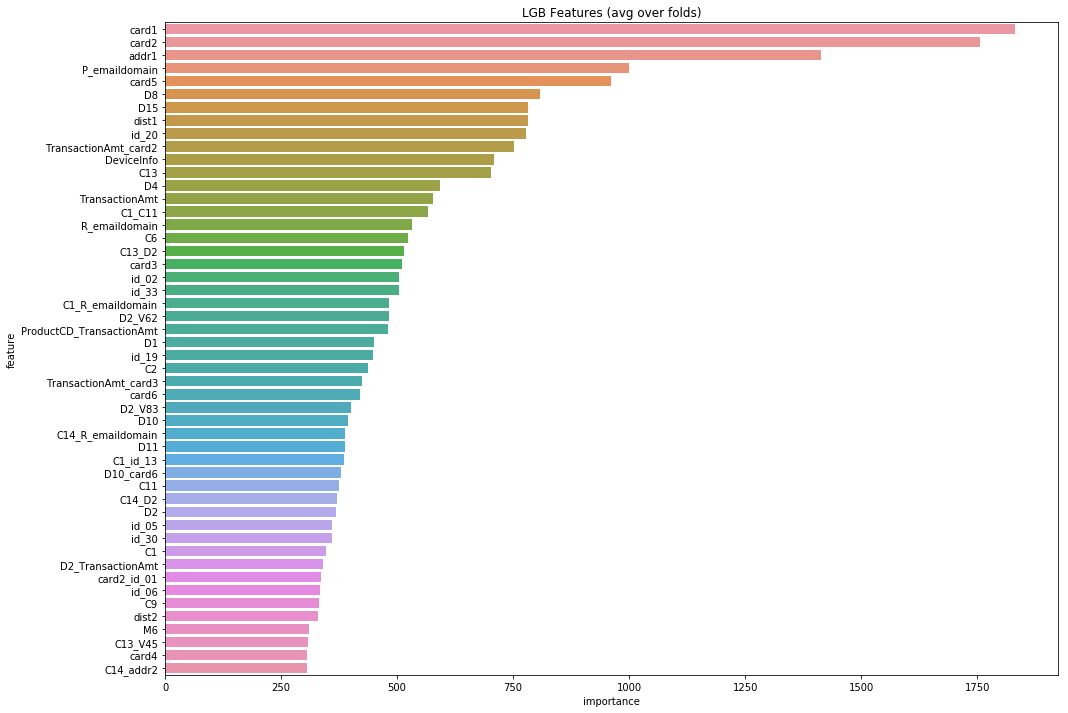

In [22]:
clf, num_iter = eval_ho(X_train, y_train, X_valid, y_valid, 
                        cols=None, lr=None, nbr=1000)

In [24]:
# clf,num_iter =eval_ts(X,y)

In [25]:
X = pd.concat([X_train, X_valid])
del X_train, X_valid
gc.collect()
y = np.concatenate([y_train, y_valid])
del y_train, y_valid
gc.collect()

7

In [26]:
dtrain=lgb.Dataset(data=X, label=y)
del X,y
gc.collect()
clf = lgb.train(lgb_params, dtrain, 
            num_boost_round=num_iter)
del dtrain
gc.collect()

67

In [27]:
test = test.sort_values('TransactionDT')
test['prediction'] = clf.predict(X_test)
sub['isFraud'] = pd.merge(sub, test, on='TransactionID')['prediction']
sub.to_csv('rus.csv', index=False)
sub.tail()

,TransactionID,isFraud
506686,4170235,0.014808
506687,4170236,0.011628
506688,4170237,0.011600
506689,4170238,0.010504
506690,4170239,0.012244
